In [18]:
%matplotlib inline

from pymc3 import Normal, Model
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 22
import seaborn

# Hierarchical Linear Regression Models in PyMC3

In this work I demonstrate how to use [PyMC3](https://github.com/pymc-devs/pymc3) with Hierarchical linear regression models. A far better post was already given by [Danne Elbars and Thomas Weicki](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/), but this is my take on it. The main difference is that I won't bother to motivate Hierarchical models, and the example that I want to apply this to is, in my opinion, a bit easier to understand than the classic Gelman radon data set. 

## Fake data

Okay so first let's create some fake data. The basic idea is that we observe $y_{\textrm{obs}}$ with some explanatory variables $x_{\textrm{obs}}$ and some noise, or more generally:

$$ y_\textrm{obs} = f(x_{\textrm{obs}}) + \epsilon$$

where $f$ is yet to be defined. Now in a linear regression we can have a number of explanatory variables, for simplicity I will just have the one, and define the function as:

$$ y_\textrm{obs} = a + b x_{\textrm{obs}} + \epsilon$$

Now comes the interesting part: let's imagine that we have $N$ observed data points, but we have reason to believe that the data is structured hierarchically. For example the physics might tell us that all the data points share a common $a$ parameter, but only groups of values share a common $b$ value. To simplify further we can say that rather than groups sharing a common $b$ value (the usual heirarchical method), in fact each data point has it's own $b$ value. This is a special case of a heirarchical model, but serves to aid understanding. In this case if we label each data point by a superscript $i$, then:

$$ y^i_\textrm{obs} = a + b^i x^i_{\textrm{obs}} + \epsilon$$

Note that all the data share a common $a$ and $\epsilon$, but take individual value of $b$. The hierarchical method, as far as I understand it, then assigns that the $b_i$ values are drawn from a *hyper-distribution*, for example 

$$ b_i \sim \mathcal{N}(\mu_b, \sigma_b) $$

Now we need some data to put some flesh on all of this:

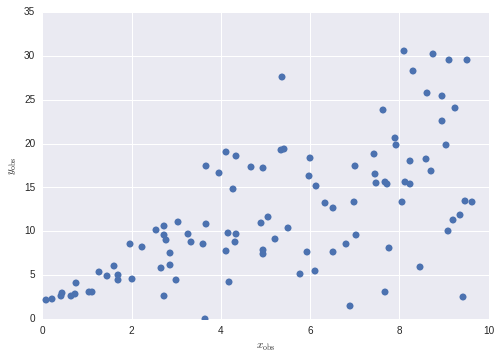

In [2]:
N = 100
a_val = 2
mu_b_val = 2
sigma_b_val = 1
b = np.random.normal(mu_b_val, sigma_b_val, N)

xobs = np.random.uniform(0, 10, N)

yobs = a_val + b * xobs

plt.plot(xobs, yobs, "o")
plt.ylabel(r"$y_\mathrm{obs}$")
plt.xlabel(r"$x_\mathrm{obs}$")
plt.show()

Note that the observerd $x$ values are randomly chosen to emulate the data collection method. 

It is important now to take stock of what we wish to learn from this. It is not the underlying values of $b_i$ which are typically of interest, instead what we really want is (1): an estimate of $a$, and (2) an estimate of the underlying distribution of the $b_i$ parameterised by the mean and standard-deviation of the normal. 

## PyMC3

This generates our model, note that $\epsilon$ enters through the standard deviation of the observed $y$ values just as in the usual linear regression (for an example see the [PyMC3 docs](https://pymc-devs.github.io/pymc3/getting_started/)). We will use diffuse priors centered on zero with a relatively large variance.

In [3]:
with pm.Model() as hierarchical_model:
    # hyperparameters
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)

    a = pm.Normal('a', mu=0, sd=100**2)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=N)
    
    eps = pm.Uniform('eps', lower=0, upper=10)
    
    mu = a + b * xobs
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=eps, observed=yobs)

Now we generate samples using the Metropolis algorithm. Note that in some of the linked examples they initiate the MCMC chains with a MLE. I found that this degraded the performance, but I don't have the time to figure out why at the moment. 

In [9]:
nsamples = 200000
nburn = 100000
with hierarchical_model:
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(nsamples, step, progressbar=True)

 [-----------------100%-----------------] 200000 of 200000 complete in 245.5 sec

Now let's use the handy `traceplot` to inspect the chains and the posteriors having discarded the first half of the samples. 

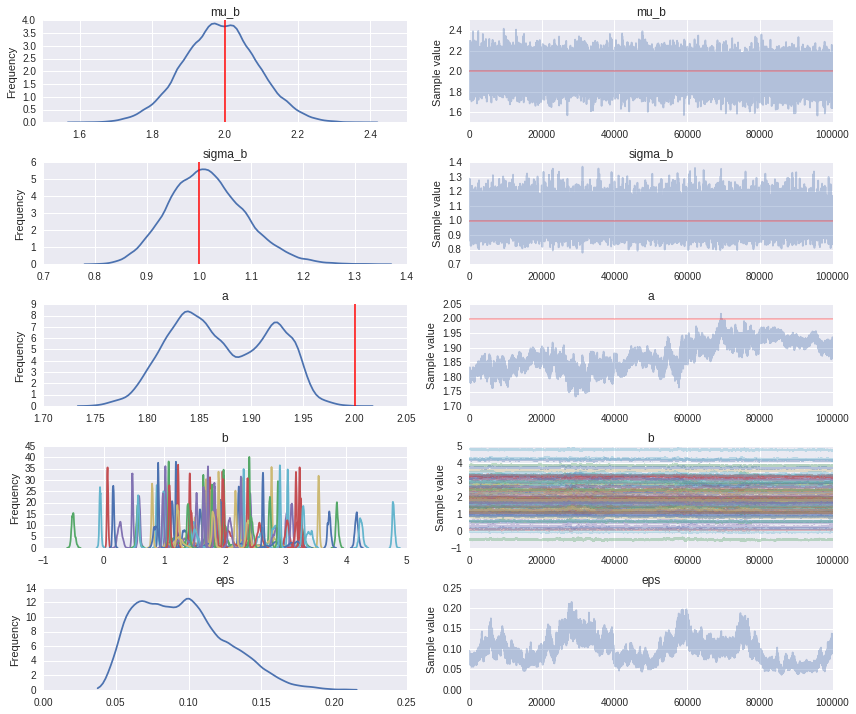

In [10]:
pm.traceplot(hierarchical_trace[nburn:], 
             lines={'mu_b': mu_b_val, 'sigma_b': sigma_b_val, 'a': a_val}
             )
plt.show()

The posterior distributions (in blue) can be compared with vertical (red) lines indicating the "true" values used to generate the data. This shows that we have not fully captured the features of the model, but compared to the diffuse prior we have learnt a great deal. Note that in generating the data $\epsilon$ was effectively zero: so the fact it's posterior is non-zero supports our understanding that we have not fully converged onto the idea solution.


## Posterior predictive check

Finally we will plot a few of the data points along with straight lines from several draws of the posterior. We color code 5 random data points, then draw 100 realisations of the parameters from the posteriors and plot the corresponding straight lines. This shows that the posterior is doing an excellent job at inferring the individual $b_i$ values.

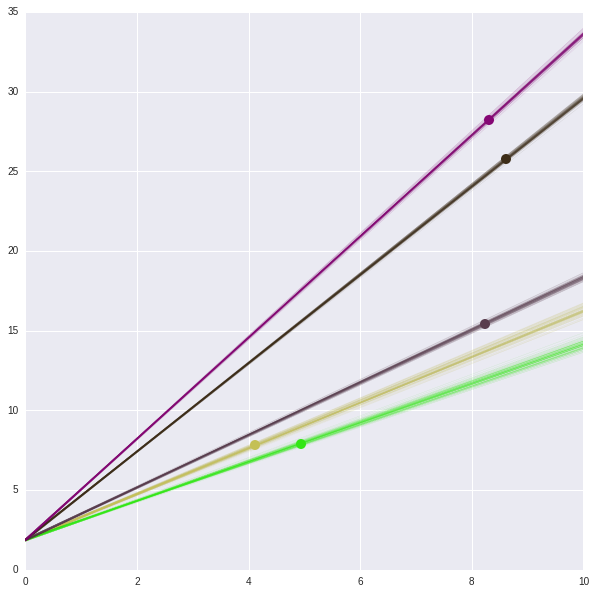

In [17]:
npp = 5
repeats = 100
fig, ax = plt.subplots(figsize=(10, 10))
xfit = np.linspace(0, 10, 100)

for i  in np.random.randint(0, N, npp):
    color = np.random.uniform(0, 1, 3)
    for j in range(repeats):
        s = hierarchical_trace[np.random.randint(nburn, nsamples)]
        yfit = s['a'] + xfit * s['b'][i]
        ax.plot(xfit, yfit, "-", lw=0.05, color=color)
    ax.plot(xobs[i], yobs[i], "o", color=color, markersize=10)
    
plt.show()